# First thing First, let us downgrade our tensorflow

In [ ]:
#Check tf version
import tensorflow as tf
#print(tf.__version__)

#The following force you to use tensorflow 2.14 but you need to restart. You may comment it if you know you are using 2.14
!pip3 install --upgrade tensorflow==2.14.0
print(tf.__version__)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 73.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 108.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: google-auth-oauthlib
    Found existing in

2.17.0


#Some imports and GPU use. Google drive connect as well



In [ ]:
#imports
import os
import numpy as np
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
print('Eager execution:', tf.executing_eagerly())
print(tf.__version__)
import matplotlib.pyplot as plt
import datetime
import pickle
import pandas as pd
import random

#Connect to drive
from google.colab import drive
drive.mount('/content/drive') # mount drive


# set random seed to be used all over
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.keras.utils.set_random_seed(SEED)
tf.compat.v1.set_random_seed(SEED)
config = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1,log_device_placement =True)
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(graph = tf.compat.v1.get_default_graph(), config = config)


Eager execution: True
2.14.0
Mounted at /content/drive
Device mapping: no known devices.


# Getting the dataset




In [ ]:
# Path to the directory containing the project files (CHANGE THIS PATH TO THE DIRECTORY ON YOUR COMPUTER)
PROJECT_ROOT_DIR = os.getcwd() + '/'

# Path to the directory containing the dataset relative to project file
DATA_DIR = 'drive/MyDrive/Datasets/CS5331_Fall24/GTSRB_dataset/'

#path to the directory you want to use for saving models relative to the project file
MODEL_DIR = 'drive/MyDrive/Datasets/CS5331_Fall24/GTSRB_dataset/'

In [ ]:
# Funciton for loading the dataset
# Code from advml-traffic-sign (https://github.com/inspire-group/advml-traffic-sign)
def load_dataset_GTSRB(n_channel=3, train_file_name=None):
    """
    Load GTSRB data as a (datasize) x (channels) x (height) x (width) numpy
    matrix. Each pixel is rescaled to the range [0,1].
    """

    def load_pickled_data(file, columns):
        """
        Loads pickled training and test data.

        Parameters
        ----------
        file    : string
                          Name of the pickle file.
        columns : list of strings
                          List of columns in pickled data we're interested in.

        Returns
        -------
        A tuple of datasets for given columns.
        """

        with open(file, mode='rb') as f:
            dataset = pickle.load(f)
        return tuple(map(lambda c: dataset[c], columns))

    def preprocess(x, n_channel):
        """
        Preprocess dataset: turn images into grayscale if specified, normalize
        input space to [0,1], reshape array to appropriate shape for NN model
        """

        if n_channel == 3:
            # Scale features to be in [0, 1]
            x = (x / 255.).astype(np.float32)
        else:
            # Convert to grayscale, e.g. single Y channel
            x = 0.299 * x[:, :, :, 0] + 0.587 * x[:, :, :, 1] + \
                0.114 * x[:, :, :, 2]
            # Scale features to be in [0, 1]
            x = (x / 255.).astype(np.float32)
            x = x[:, :, :, np.newaxis]
        return x

    # Load pickle dataset
    if train_file_name is None:
        x_train, y_train = load_pickled_data(
            PROJECT_ROOT_DIR + DATA_DIR + 'train.p', ['features', 'labels'])
    else:
        x_train, y_train = load_pickled_data(
            PROJECT_ROOT_DIR + DATA_DIR + train_file_name, ['features', 'labels'])
    x_val, y_val = load_pickled_data(
        PROJECT_ROOT_DIR + DATA_DIR + 'valid.p', ['features', 'labels'])
    x_test, y_test = load_pickled_data(
        PROJECT_ROOT_DIR + DATA_DIR + 'test.p', ['features', 'labels'])

    # Preprocess loaded data
    x_train = preprocess(x_train, n_channel)
    x_val = preprocess(x_val, n_channel)
    x_test = preprocess(x_test, n_channel)
    return x_train, y_train, x_val, y_val, x_test, y_test

In [ ]:
# Load the images and labels. These images are RGB so we have 3 channels
imgs_train, labels_train, imgs_val, labels_val, imgs_test, labels_test = load_dataset_GTSRB(n_channel=3)

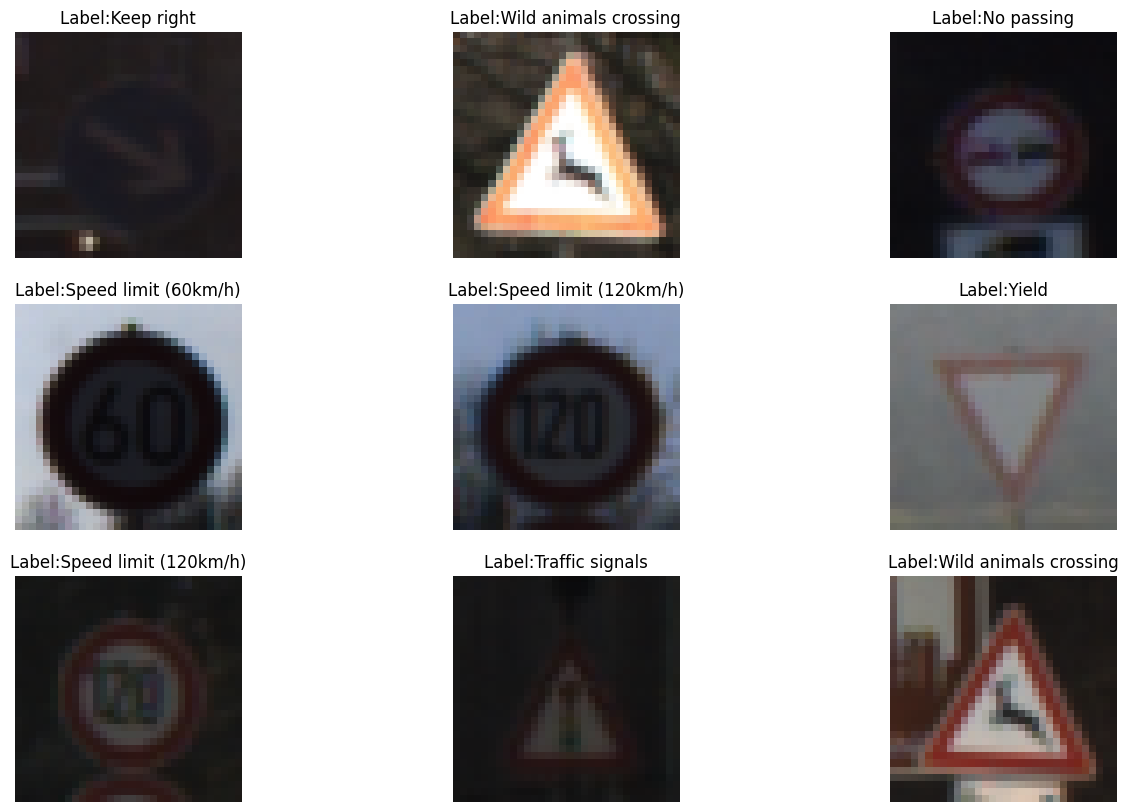

In [ ]:
# Read the sign names
signnames = pd.read_csv(PROJECT_ROOT_DIR + '/drive/MyDrive/Datasets/CS5331_Fall24/GTSRB_dataset/signnames.csv').values[:, 1]

# Plot a few images to check if the data makes sense (note that the quality of some of the images is pretty low)
plt.figure(figsize=(16, 10))
for n in range(9):
    i = np.random.randint(0, len(imgs_train), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(imgs_train[i[0]])
    plt.title('Label:' + str(signnames[labels_train[i[0]]]))
    plt.axis('off')

#Hyperparameters for training

In [ ]:
# Set constants (GTSRB)
NUM_LABELS = 43                             # Number of labels or classes for classification
BATCH_SIZE = 128                            # Size of batch
HEIGHT = 32                                 # Height of input image
WIDTH = 32                                  # Width of input image
N_CHANNEL = 3                               # Number of channels
OUTPUT_DIM = 43                             # Number of output dimension

# Set training hyperparameters
NUM_EPOCH = 50                             # Number of epoch to train
LR = 0.0002                                 # Learning rate
RBW = True #restore best weights
PATIENCE = 5# how many epochs between improvements

INPUT_SHAPE = (HEIGHT, WIDTH, N_CHANNEL)  # Input shape of model
IMG_SHAPE = (HEIGHT, WIDTH, N_CHANNEL)

#Some preprocessing

In [ ]:
#avoiding future overfitting
from tensorflow.keras.callbacks import EarlyStopping

callbacks = [EarlyStopping(monitor='val_loss',
                   patience = PATIENCE,
                   restore_best_weights=RBW)]

In [ ]:
# setting up labels
from tensorflow.keras.utils import to_categorical

#Convert the labels to one-hot encoding (to input to the models)

#make a copy of 500 test images before we encode for adversarial testing.
imgs_adv = imgs_test[0:500,:,:,:].copy()
labels_adv = labels_test[0:500].copy()




labels_train_cat = to_categorical(labels_train, NUM_LABELS)
labels_test_cat = to_categorical(labels_test, NUM_LABELS)
labels_val_cat = to_categorical(labels_val, NUM_LABELS)

#for testing adversarial inputs
labels_adv_cat = to_categorical(labels_adv,NUM_LABELS)

print('Labels train shape: {}'.format(labels_train.shape))
print('Labels train catagorical shape: {}\n'.format(labels_train_cat.shape))
print('Labels Adver shape: {}'.format(labels_adv.shape))
print('Labels Adver catagorical shape: {}'.format(labels_adv_cat.shape))

print('Imgs Adver shape: {}'.format(imgs_adv.shape))

Labels train shape: (34799,)
Labels train catagorical shape: (34799, 43)

Labels Adver shape: (500,)
Labels Adver catagorical shape: (500, 43)
Imgs Adver shape: (500, 32, 32, 3)


# Build our deep learning model


In [ ]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model


#create our model
def build_model():
    #create VGG16 model with properties we want.
    base_model = tf.keras.applications.VGG16(include_top=False,
                                    weights="imagenet",
                                    input_shape=INPUT_SHAPE)

    #create fully connected layers
    #by not including the top we need to create these layers ourselves
    #input and output layers
    # Add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # Add a fully-connected layer
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.25)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.25)(x)
    # Add a softmax layer with 43 classes
    predictions = Dense(OUTPUT_DIM, activation='softmax', name ='softmax')(x)

    # The model
    model = Model(inputs=base_model.input, outputs=predictions)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss='categorical_crossentropy',
              metrics = ['accuracy'])



    return model



In [ ]:
# Training the model

##It will take alot of time to train the model. Thus, uncomment the following, build the model, save it and comment it back in your next run
## the code to save the move is available next.
'''
model = build_model()

t = datetime.datetime.now()

#fit the model
history = model.fit(x= imgs_train,
    y= labels_train_cat,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCH,
    # monitoring validation loss and metrics
    validation_data=(imgs_val, labels_val_cat),
    verbose=1,
    callbacks=callbacks)

print('Training time: %s\n' % (datetime.datetime.now() - t))



# Evaluate on train,validation,test images
t = datetime.datetime.now()
evals_test = model.evaluate(imgs_test, labels_test_cat)
print("Classification Accuracy Test: ", evals_test[1])
print('Inference time: %s \n' % (datetime.datetime.now() - t))



t = datetime.datetime.now()
evals_test = model.evaluate(imgs_val, labels_val_cat)
print("Classification Accuracy Validation: ", evals_test[1])
print('Inference time: %s \n' % (datetime.datetime.now() - t))



t = datetime.datetime.now()
evals_test = model.evaluate(imgs_train, labels_train_cat)
print("Classification Accuracy Train: ", evals_test[1])
print('Inference time: %s' % (datetime.datetime.now() - t))
'''

'\nmodel = build_model()\n\nt = datetime.datetime.now()\n\n#fit the model\nhistory = model.fit(x= imgs_train,\n    y= labels_train_cat,\n    batch_size=BATCH_SIZE,\n    epochs=NUM_EPOCH,\n    # monitoring validation loss and metrics\n    validation_data=(imgs_val, labels_val_cat),\n    verbose=1,\n    callbacks=callbacks)\n\nprint(\'Training time: %s\n\' % (datetime.datetime.now() - t))\n\n\n\n# Evaluate on train,validation,test images\nt = datetime.datetime.now()\nevals_test = model.evaluate(imgs_test, labels_test_cat)\nprint("Classification Accuracy Test: ", evals_test[1])\nprint(\'Inference time: %s \n\' % (datetime.datetime.now() - t))\n\n\n\nt = datetime.datetime.now()\nevals_test = model.evaluate(imgs_val, labels_val_cat)\nprint("Classification Accuracy Validation: ", evals_test[1])\nprint(\'Inference time: %s \n\' % (datetime.datetime.now() - t))\n\n\n\nt = datetime.datetime.now()\nevals_test = model.evaluate(imgs_train, labels_train_cat)\nprint("Classification Accuracy Train: "

In [ ]:
## Load the saved the model
from tensorflow.keras.models import load_model


#The followiwng line should be uncommented with your first run (to save the model)
#model.save(MODEL_DIR +'VGG_best.keras')


#load our already trained model
# Your earlier directories should change to match this one
#You should be able to load the model once trained. The following line is used for that.
model = load_model( MODEL_DIR +'VGG_best.h5')



##Task 1:  Untargeted attacks
# CS5331/CS4331 You should Impliment this part
Let’s start with basic non-target white-box attacks. First, we will implement some non-target white-box attacks we studied in class. Your downloaded code from Blackboard will build a VGG16 model for you. You will attack that deep learning model throughout the assignment.

This task aims to implement the following attacks: Fast Gradient Sign Method (FGSM), Projected Gradient Descent (PGD), Deep Fool, and C&W with L2 norm. You don’t need to implement these attacks from scratch. Code for them can be in several libraries, including Adversarial Robustness Toolbox (ART), cleverhans, or scratchai (Just traditional libraries. Maybe there are better ones now). Using ART for this assignment is recommended, but using any other libraries of your choice is also acceptable. This [notebook](https://https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/art-for-tensorflow-v2-keras.ipynb) is a good start on how to use ART, and multiple other notebooks are available here.

Your task is to apply attacks to create non-target adversarial examples using the first 500 images of your test set (check imgs_adv and labels_adv in your code). For FSGM, PGD, and DeepFool, apply perturbations magnitudes: 𝜖= [0.05, 0.1, 0.2, 0.25, 0.3]. For C&W, use the L2 norm to perform the attack. You should provide us with the following results.

Then

1- Plot the clean image vs adversarial image for three images of your choice

2- For two images of choice, plot the clean image vs. adversarial images of all attacks (if the perturbation is needed, choose 𝜖= [0.1]).

3- Fill out Table 1 and Table 2 for accuracy and add the noise of each attack.

4- Plot accuracy versus perturbation 𝜖 for FSGM and PGD adversarial attacks (similar to the example in the following figure).


In [ ]:
#Install ART if you have not done that
!pip install adversarial-robustness-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 17.3 MB/s eta 0:00:00


#Impliment and generate results for FGSM

In [ ]:
#Get your correct imports
import tensorflow as tf
from tensorflow.keras.models import load_model
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent, DeepFool, CarliniL2Method
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Disable eager execution
tf.compat.v1.disable_eager_execution()

# Load the pre-trained VGG16 model
model = load_model(MODEL_DIR + 'VGG_best.h5')

# Create the ART classifier
classifier = KerasClassifier(model=model, clip_values=(0, 1))

In [ ]:
# #Create the ART attacker
epsilons = [0.05, 0.1, 0.2, 0.25, 0.3]
fgsm_attackers = {}
for eps in epsilons:
    fgsm_attackers[eps] = FastGradientMethod(estimator=classifier, eps=eps)


# #Generate your adv. samples
# adv_samples_fgsm = {}
# for eps in epsilons:
#     adv_samples_fgsm[eps] = fgsm_attackers[eps].generate(x=imgs_adv)

In [ ]:
# #Generate the results
# accuracy_fgsm = {}
# for eps in epsilons:
#     preds_adv = classifier.predict(adv_samples_fgsm[eps])
#     accuracy_fgsm[eps] = np.mean(np.argmax(preds_adv, axis=1) == np.argmax(labels_adv_cat, axis=1))
#     print(f"FGSM Attack Accuracy for eps={eps}: {accuracy_fgsm[eps]}")

# #Save the results
# for eps in epsilons:
#     np.save(MODEL_DIR + f'adv_samples_fgsm_eps_{eps}.npy', adv_samples_fgsm[eps])
# np.save(MODEL_DIR + 'fgsm_accuracy_results.npy', accuracy_fgsm)

In [ ]:
# Load the adversarial samples for each epsilon value
adv_samples_fgsm = {}
for eps in epsilons:
    adv_samples_fgsm[eps] = np.load(MODEL_DIR + f'adv_samples_fgsm_eps_{eps}.npy')

# Load the accuracy results
accuracy_fgsm = np.load(MODEL_DIR + 'fgsm_accuracy_results.npy', allow_pickle=True).item()
# Print the accuracy for each epsilon value
for eps in epsilons:
    print(f"FGSM Attack Accuracy for eps={eps}: {accuracy_fgsm[eps]}")

FGSM Attack Accuracy for eps=0.05: 0.274
FGSM Attack Accuracy for eps=0.1: 0.226
FGSM Attack Accuracy for eps=0.2: 0.172
FGSM Attack Accuracy for eps=0.25: 0.154
FGSM Attack Accuracy for eps=0.3: 0.142


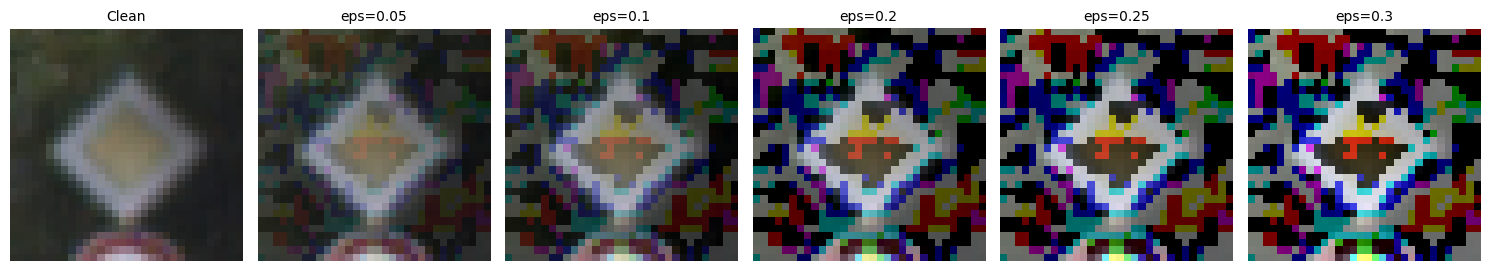

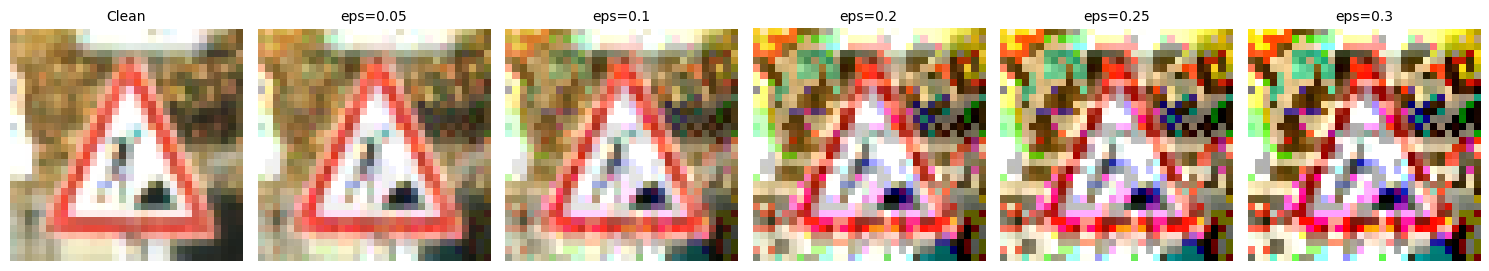

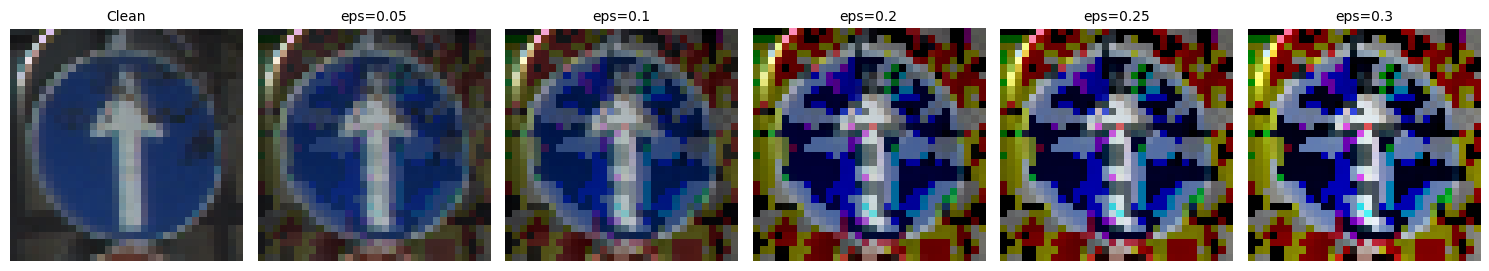

In [ ]:
#show figures for different eps
indices = [7, 8, 9]

for idx in indices:
    plt.figure(figsize=(15, 5))
    plt.subplot(1, len(epsilons) + 1, 1)
    plt.imshow(imgs_adv[idx])
    plt.title('Clean', fontsize=10)
    plt.axis('off')

    for j, eps in enumerate(epsilons):
        plt.subplot(1, len(epsilons) + 1, j + 2)
        plt.imshow(adv_samples_fgsm[eps][idx])
        plt.title(f'eps={eps}', fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

#Impliment and generate results for PGD

In [ ]:
#Get your correct imports
import tensorflow as tf
from tensorflow.keras.models import load_model
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import ProjectedGradientDescent
import numpy as np
import matplotlib.pyplot as plt

#Create the ART classifier
model = load_model(MODEL_DIR + 'VGG_best.h5')
classifier = KerasClassifier(model=model, clip_values=(0, 1))

In [ ]:
# #Create the ART attacker
epsilons = [0.05, 0.1, 0.2, 0.25, 0.3]
pgd_attackers = {}

for eps in epsilons:
    pgd_attackers[eps] = ProjectedGradientDescent(estimator=classifier, eps=eps, max_iter=20)

# #Generate your adv. samples
# adv_samples_pgd = {}

# for eps in epsilons:
#     adv_samples_pgd[eps] = pgd_attackers[eps].generate(x=imgs_adv)

# #Generate the results
# accuracy_pgd = {}

# for eps in epsilons:
#     preds_adv = classifier.predict(adv_samples_pgd[eps])
#     accuracy_pgd[eps] = np.mean(np.argmax(preds_adv, axis=1) == np.argmax(labels_adv_cat, axis=1))
#     print(f"PGD Attack Accuracy for eps={eps}: {accuracy_pgd[eps]}")

PGD Attack Accuracy for eps=0.05: 0.236
PGD Attack Accuracy for eps=0.1: 0.08
PGD Attack Accuracy for eps=0.2: 0.078
PGD Attack Accuracy for eps=0.25: 0.078
PGD Attack Accuracy for eps=0.3: 0.078


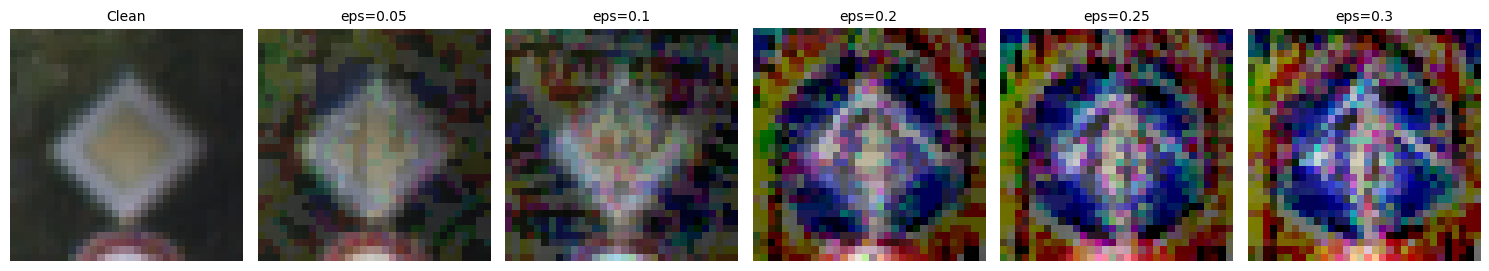

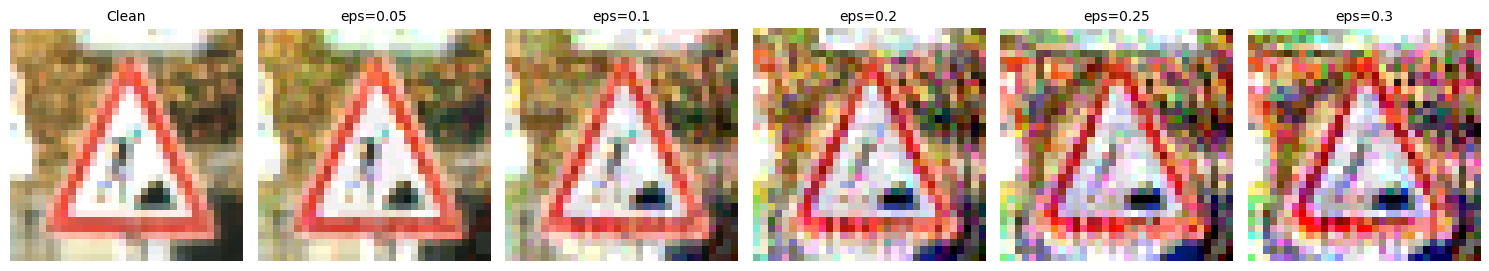

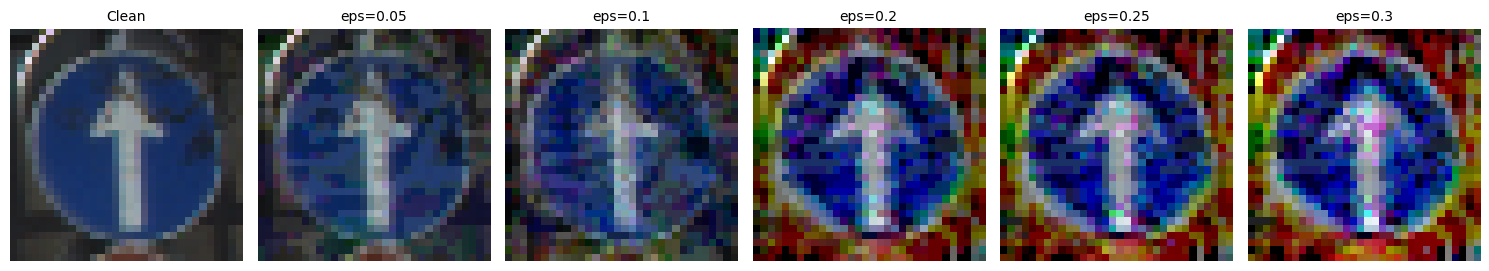

In [ ]:
# #Save the results
# for eps in epsilons:
#     np.save(MODEL_DIR + f'adv_samples_pgd_eps_{eps}.npy', adv_samples_pgd[eps])

# np.save(MODEL_DIR + 'pgd_accuracy_results.npy', accuracy_pgd)

# Load the adversarial samples for each epsilon value
adv_samples_pgd = {}
for eps in epsilons:
    adv_samples_pgd[eps] = np.load(MODEL_DIR + f'adv_samples_pgd_eps_{eps}.npy')

# Load the accuracy results
accuracy_pgd = np.load(MODEL_DIR + 'pgd_accuracy_results.npy', allow_pickle=True).item()
# Print the accuracy for each epsilon value
for eps in epsilons:
    print(f"PGD Attack Accuracy for eps={eps}: {accuracy_pgd[eps]}")


#show figures for different eps
indices = [7, 8, 9]

for idx in indices:
    plt.figure(figsize=(15, 5))
    plt.subplot(1, len(epsilons) + 1, 1)
    plt.imshow(imgs_adv[idx])
    plt.title('Clean', fontsize=10)
    plt.axis('off')

    for j, eps in enumerate(epsilons):
        plt.subplot(1, len(epsilons) + 1, j + 2)
        plt.imshow(adv_samples_pgd[eps][idx])
        plt.title(f'eps={eps}', fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

#Impliment and generate results for Deep fool



In [ ]:
#Get your correct imports
import tensorflow as tf
from tensorflow.keras.models import load_model
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import DeepFool
import numpy as np
import matplotlib.pyplot as plt


#Create the ART classifier
model = load_model(MODEL_DIR + 'VGG_best.h5')
classifier = KerasClassifier(model=model, clip_values=(0, 1))


#Create the ART attacker
deepfool = DeepFool(classifier)

In [ ]:
#Generate your adv. samples
# adv_samples_deepfool = deepfool.generate(x=imgs_adv)

# Apply scaling for each epsilon
epsilons = [0.05, 0.1, 0.2, 0.25, 0.3]
# adv_samples_deepfool_scaled = {}

# for eps in epsilons:
#     adv_samples_deepfool_scaled[eps] = imgs_adv + eps * (adv_samples_deepfool - imgs_adv)

# #Generate the results
# accuracy_deepfool_scaled = {}

# for eps in epsilons:
#     preds_adv = classifier.predict(adv_samples_deepfool_scaled[eps])
#     accuracy_deepfool_scaled[eps] = np.mean(np.argmax(preds_adv, axis=1) == np.argmax(labels_adv_cat, axis=1))
#     print(f"DeepFool Attack Accuracy for eps={eps}: {accuracy_deepfool_scaled[eps]}")

In [ ]:
# #Save the results
# for eps in epsilons:
#     np.save(MODEL_DIR + f'adv_samples_deepfool_eps_{eps}.npy', adv_samples_deepfool_scaled[eps])

# np.save(MODEL_DIR + 'deepfool_accuracy_results.npy', accuracy_deepfool_scaled)

# #show figures for different eps
# indices = [7, 8, 9]

# for idx in indices:
#     plt.figure(figsize=(15, 5))

#     plt.subplot(1, len(epsilons) + 1, 1)
#     plt.imshow(imgs_adv[idx])
#     plt.title('Clean', fontsize=10)
#     plt.axis('off')

#     for j, eps in enumerate(epsilons):
#         plt.subplot(1, len(epsilons) + 1, j + 2)
#         plt.imshow(adv_samples_deepfool_scaled[eps][idx])
#         plt.title(f'eps={eps}', fontsize=10)
#         plt.axis('off')

#     plt.tight_layout()
#     plt.show()

In [ ]:
# Load the adversarial samples for each epsilon
adv_samples_deepfool_scaled = {}

for eps in epsilons:
    adv_samples_deepfool_scaled[eps] = np.load(MODEL_DIR + f'adv_samples_deepfool_eps_{eps}.npy')
    # print(f"Loaded adv_samples_deepfool_scaled for eps={eps}")
    # print(f"Shape of adv_samples_deepfool_scaled for eps={eps}: {adv_samples_deepfool_scaled[eps].shape}")

# Load the accuracy results
accuracy_deepfool_scaled = np.load(MODEL_DIR + 'deepfool_accuracy_results.npy', allow_pickle=True).item()



# Print the accuracy for each epsilon
for eps in epsilons:
    print(f"DeepFool Attack Accuracy for eps={eps}: {accuracy_deepfool_scaled[eps]}")

DeepFool Attack Accuracy for eps=0.05: 0.694
DeepFool Attack Accuracy for eps=0.1: 0.436
DeepFool Attack Accuracy for eps=0.2: 0.284
DeepFool Attack Accuracy for eps=0.25: 0.264
DeepFool Attack Accuracy for eps=0.3: 0.254


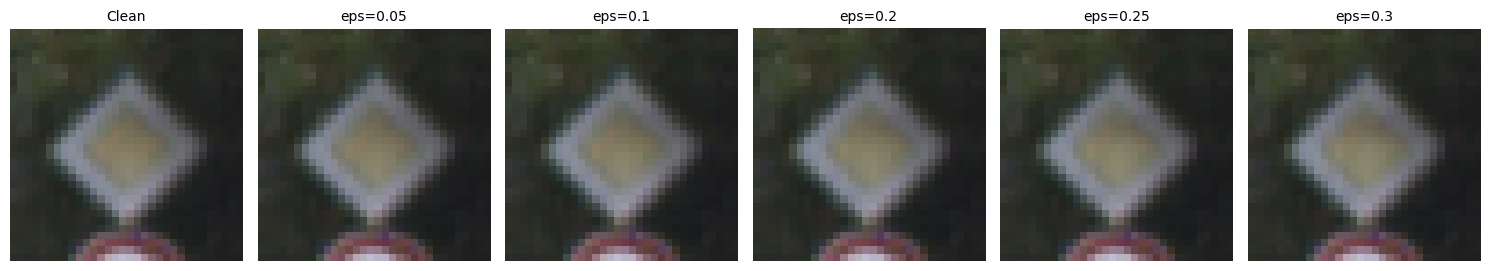

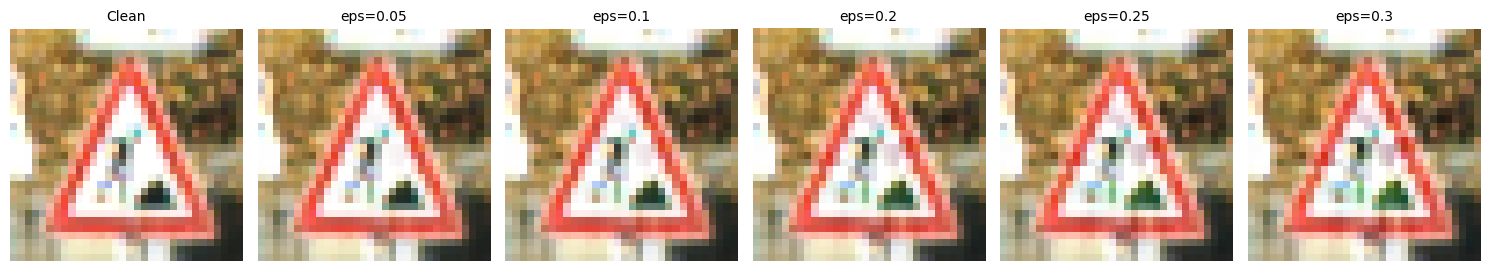

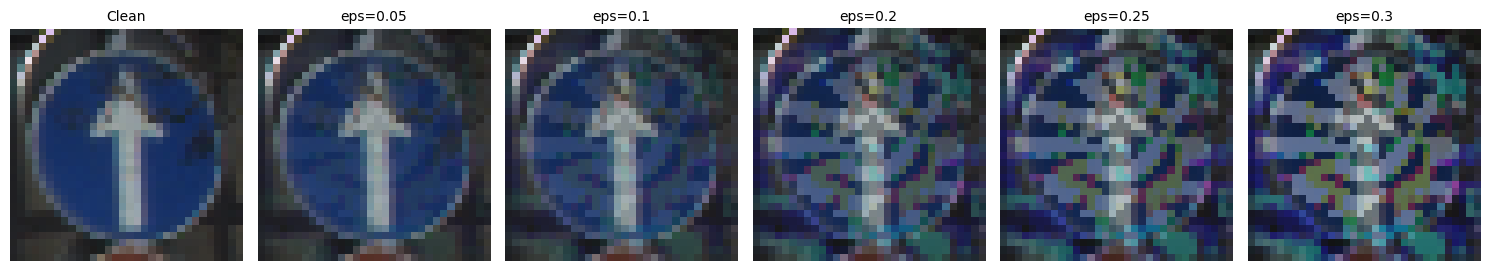

In [ ]:
# Use the saved adversarial samples to plot
indices = [7, 8, 9]

for idx in indices:
    plt.figure(figsize=(15, 5))  # Adjust the figure size

    # Plot the clean image
    plt.subplot(1, len(epsilons) + 1, 1)
    plt.imshow(imgs_adv[idx])
    plt.title('Clean', fontsize=10)
    plt.axis('off')

    # Plot the adversarial images for each epsilon
    for j, eps in enumerate(epsilons):
        plt.subplot(1, len(epsilons) + 1, j + 2)
        plt.imshow(adv_samples_deepfool_scaled[eps][idx])
        plt.title(f'eps={eps}', fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

#Impliment and generate results for C&W2

In [ ]:
#Do the same for C&W
#Make sure you are using L2 norm

In [ ]:
#Get your correct imports
import tensorflow as tf
from tensorflow.keras.models import load_model
from art.estimators.classification import KerasClassifier
from art.attacks.evasion import CarliniL2Method
import numpy as np
import matplotlib.pyplot as plt


#Create the ART classifier
model = load_model(MODEL_DIR + 'VGG_best.h5')
classifier = KerasClassifier(model=model, clip_values=(0, 1))


#Create the ART attacker
cw_l2 = CarliniL2Method(classifier, targeted=False, max_iter=5)

In [ ]:
# Generate your adv. samples
# adv_samples_cw_l2 = cw_l2.generate(x=imgs_adv)

# Apply scaling for each epsilon
# epsilons = [0.05, 0.1, 0.2, 0.25, 0.3]
# adv_samples_cw_l2_scaled = {}

# for eps in epsilons:
#     adv_samples_cw_l2_scaled[eps] = imgs_adv + eps * (adv_samples_cw_l2 - imgs_adv)

In [ ]:
# #Generate the results
# accuracy_cw_l2_scaled = {}

# for eps in epsilons:
#     preds_adv = classifier.predict(adv_samples_cw_l2_scaled[eps])
#     accuracy_cw_l2_scaled[eps] = np.mean(np.argmax(preds_adv, axis=1) == np.argmax(labels_adv_cat, axis=1))
#     print(f"C&W L2 Attack Accuracy for eps={eps}: {accuracy_cw_l2_scaled[eps]}")

C&W L2 Attack Accuracy for eps=0.05: 0.938
C&W L2 Attack Accuracy for eps=0.1: 0.938
C&W L2 Attack Accuracy for eps=0.2: 0.926
C&W L2 Attack Accuracy for eps=0.25: 0.92
C&W L2 Attack Accuracy for eps=0.3: 0.912


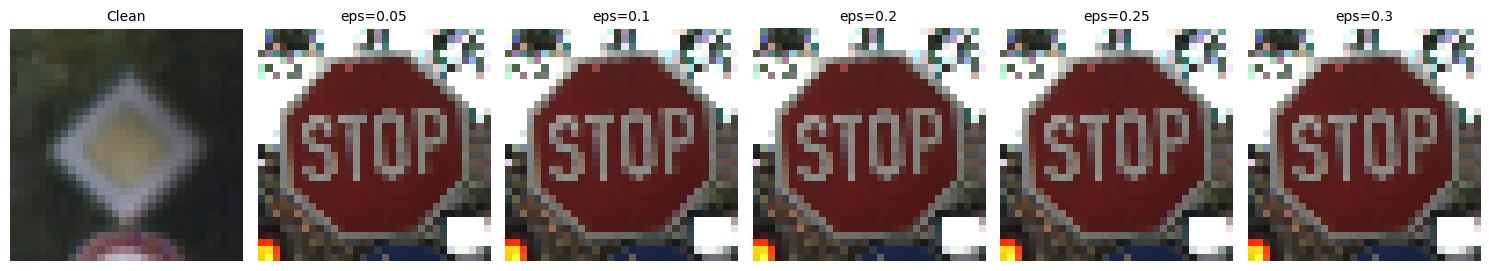

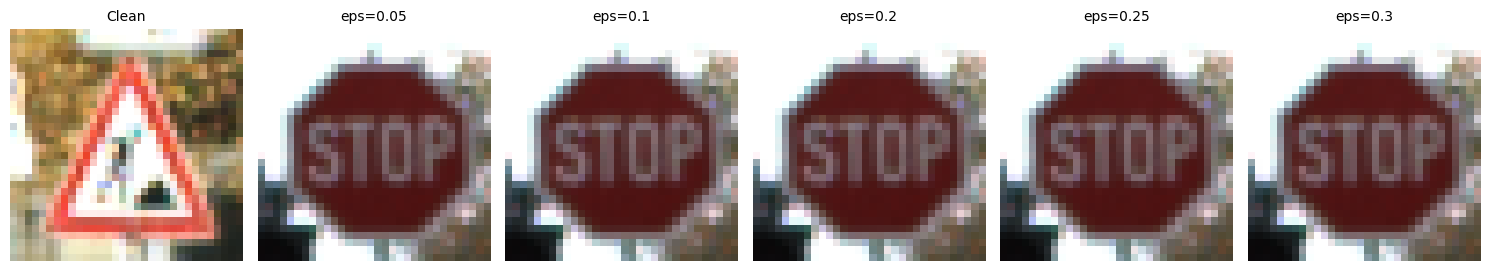

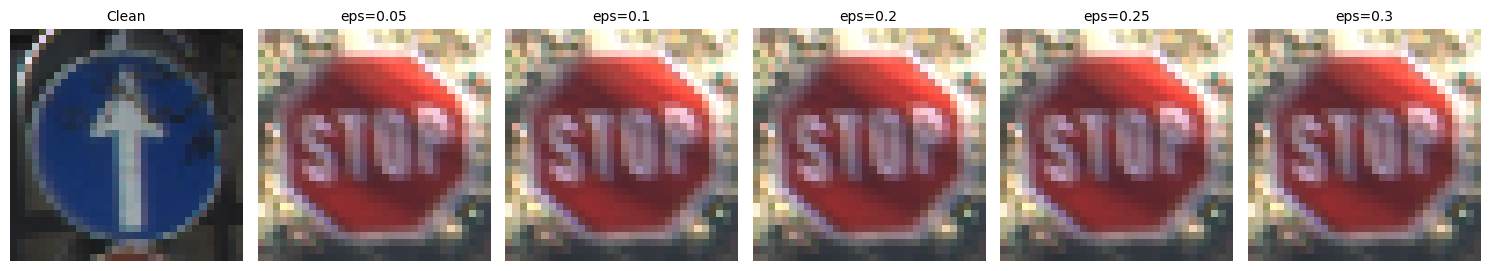

In [ ]:
#Save the results
# for eps in epsilons:
#     np.save(MODEL_DIR + f'adv_samples_cw_l2_eps_{eps}.npy', adv_samples_cw_l2_scaled[eps])

# # Save the accuracy results
# np.save(MODEL_DIR + 'cw_l2_accuracy_results.npy', accuracy_cw_l2_scaled)

# Load the saved adversarial samples for each epsilon
adv_samples_cw_l2_scaled = {}
for eps in epsilons:
    adv_samples_cw_l2_scaled[eps] = np.load(MODEL_DIR + f'adv_samples_cw_l2_eps_{eps}.npy')

# Load the saved accuracy results
accuracy_cw_l2_scaled = np.load(MODEL_DIR + 'cw_l2_accuracy_results.npy', allow_pickle=True).item()

# Now you can print the saved results
for eps in epsilons:
    print(f"C&W L2 Attack Accuracy for eps={eps}: {accuracy_cw_l2_scaled[eps]}")

# Define the indices of images to visualize
indices = [7, 8, 9]

for idx in indices:
    plt.figure(figsize=(15, 5))

    # Plot the clean image
    plt.subplot(1, len(epsilons) + 1, 1)
    plt.imshow(imgs_adv[idx])
    plt.title('Clean', fontsize=10)
    plt.axis('off')

    # Plot the adversarial images for each epsilon
    for j, eps in enumerate(epsilons):
        plt.subplot(1, len(epsilons) + 1, j + 2)
        plt.imshow(adv_samples_cw_l2_scaled[eps][idx])
        plt.title(f'eps={eps}', fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()


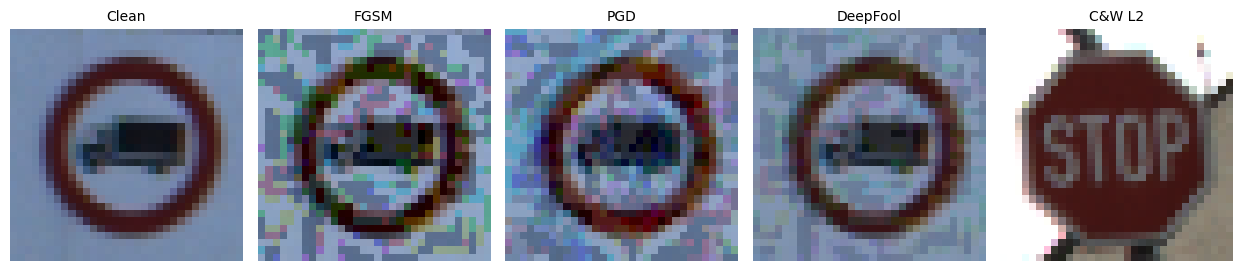

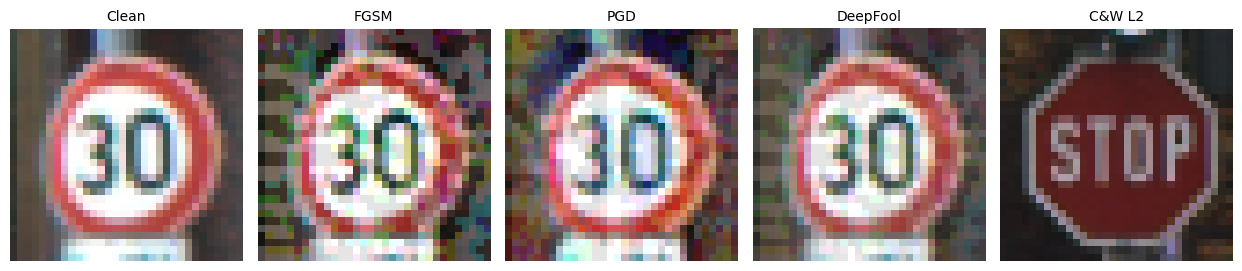

In [ ]:
# Set the epsilon value to 0.1 for all attacks
epsilon = 0.1
indices = [0, 1]

# Plot clean vs adversarial images for FGSM, PGD, DeepFool, and C&W
for idx in indices:
    plt.figure(figsize=(15, 5))

    # Plot the clean image
    plt.subplot(1, 6, 1)
    plt.imshow(imgs_adv[idx])
    plt.title('Clean', fontsize=10)
    plt.axis('off')

    # Plot FGSM adversarial image
    plt.subplot(1, 6, 2)
    plt.imshow(adv_samples_fgsm[epsilon][idx])
    plt.title('FGSM', fontsize=10)
    plt.axis('off')

    # Plot PGD adversarial image
    plt.subplot(1, 6, 3)
    plt.imshow(adv_samples_pgd[epsilon][idx])
    plt.title('PGD', fontsize=10)
    plt.axis('off')

    # Plot DeepFool adversarial image
    plt.subplot(1, 6, 4)
    plt.imshow(adv_samples_deepfool_scaled[epsilon][idx])
    plt.title('DeepFool', fontsize=10)
    plt.axis('off')

    # Plot C&W L2 adversarial image
    plt.subplot(1, 6, 5)
    plt.imshow(adv_samples_cw_l2_scaled[epsilon][idx])
    plt.title('C&W L2', fontsize=10)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Get predictions on clean images (no adversarial attacks)
preds_clean = classifier.predict(imgs_adv)

# Calculate accuracy by comparing predicted labels with true labels
clean_image_accuracy = np.mean(np.argmax(preds_clean, axis=1) == np.argmax(labels_adv_cat, axis=1))
print(f"Clean Image Accuracy: {clean_image_accuracy}")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


Clean Image Accuracy: 0.938


In [ ]:
import numpy as np

def calculate_noise(clean_images, adv_images):
    return np.mean(np.linalg.norm((adv_images - clean_images).reshape(adv_images.shape[0], -1), axis=1))

noise_fgsm = {}
noise_pgd = {}
noise_deepfool = {}

# Calculate noise for FGSM
for eps in epsilons:
    noise_fgsm[eps] = calculate_noise(imgs_adv, adv_samples_fgsm[eps])
    print(f"FGSM Noise for eps={eps}: {noise_fgsm[eps]}")

# Calculate noise for PGD
for eps in epsilons:
    noise_pgd[eps] = calculate_noise(imgs_adv, adv_samples_pgd[eps])
    print(f"PGD Noise for eps={eps}: {noise_pgd[eps]}")

# Calculate noise for DeepFool
for eps in epsilons:
    noise_deepfool[eps] = calculate_noise(imgs_adv, adv_samples_deepfool_scaled[eps])
    print(f"DeepFool Noise for eps={eps}: {noise_deepfool[eps]}")

# Calculate noise for C&W L2 (no epsilon, single calculation)
# noise_cw_l2 = calculate_noise(imgs_adv, adv_samples_cw_l2)
# print(f"C&W L2 Noise: {noise_cw_l2}")

FGSM Noise for eps=0.05: 2.7244961261749268
FGSM Noise for eps=0.1: 5.313330173492432
FGSM Noise for eps=0.2: 9.989194869995117
FGSM Noise for eps=0.25: 12.150802612304688
FGSM Noise for eps=0.3: 14.226563453674316
PGD Noise for eps=0.05: 2.724621534347534
PGD Noise for eps=0.1: 4.480292797088623
PGD Noise for eps=0.2: 8.032236099243164
PGD Noise for eps=0.25: 9.524332046508789
PGD Noise for eps=0.3: 10.997124671936035
DeepFool Noise for eps=0.05: 0.6234214901924133
DeepFool Noise for eps=0.1: 1.2468429803848267
DeepFool Noise for eps=0.2: 2.4936859607696533
DeepFool Noise for eps=0.25: 3.117107391357422
DeepFool Noise for eps=0.3: 3.7405288219451904


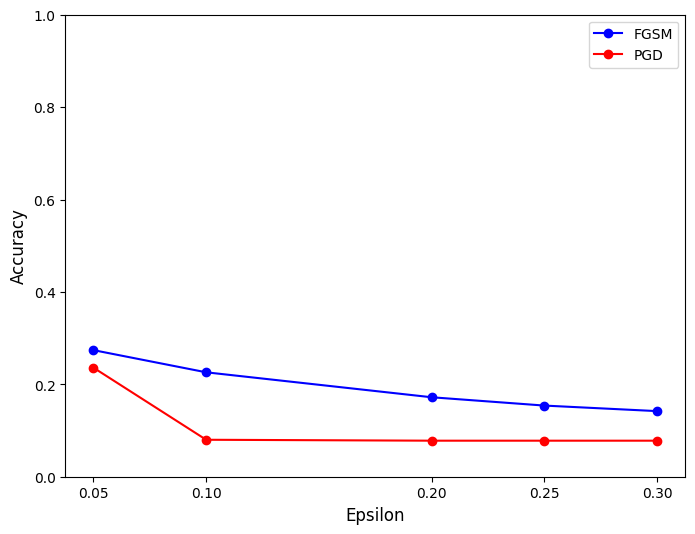

In [ ]:
import matplotlib.pyplot as plt

# Epsilon values
epsilons = [0.05, 0.1, 0.2, 0.25, 0.3]
accuracy_fgsm = [0.274, 0.226, 0.172, 0.154, 0.142]
accuracy_pgd = [0.236, 0.08, 0.078, 0.078, 0.078]

plt.figure(figsize=(8, 6))
plt.plot(epsilons, accuracy_fgsm, label='FGSM', marker='o', linestyle='-', color='b')
plt.plot(epsilons, accuracy_pgd, label='PGD', marker='o', linestyle='-', color='r')

plt.xlabel('Epsilon', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(epsilons)
plt.ylim([0, 1])

plt.legend()
plt.show()

##Task 2 targeted attacks

Now, let’s do some target attacks with white-box assumptions. Use the images with the Stop sign (label 14) from the overall test set for this task. There are around 270 images of that kind. Implement FGSM attacks on the Stop sign images to misclassify them as speed 30 sign images (label 1). Apply perturbations magnitudes: 𝜖= [0.05, 0.1, 0.2, 0.25, 0.3] for these attacks and report the classification accuracy on the Stop sign images and the Speed Limit 30 sign images.

Apply the same thing using PGD attacks and compare the results.
Apply the same thing using C&W attacks (perturbations magnitudes) and compare the results.


Then:

1- Plot the clean image vs adversarial image

2- Fill out Table 3 for accuracies.



In [ ]:
#Do targetted for three attacks. You can follow the same steps

In [ ]:
# Extract Stop sign images (label 14) and their corresponding labels
stop_sign_indices = np.where(labels_test == 14)[0]
stop_sign_images = imgs_test[stop_sign_indices]
stop_sign_labels = labels_test_cat[stop_sign_indices]

# Target label for misclassification (Speed Limit 30 - label 1)
target_labels = np.ones_like(stop_sign_labels)  # Set all target labels to Speed Limit 30 (label 1)

In [ ]:
epsilons = [0.05, 0.1, 0.2, 0.25, 0.3]
fgsm_attackers = {}

for eps in epsilons:
    fgsm_attackers[eps] = FastGradientMethod(estimator=classifier, eps=eps, targeted=True)

In [ ]:
adv_samples_fgsm_targeted = {}

for eps in epsilons:
    adv_samples_fgsm_targeted[eps] = fgsm_attackers[eps].generate(x=stop_sign_images, y=target_labels)

In [ ]:
accuracy_fgsm_targeted = {}

for eps in epsilons:
    preds_adv = classifier.predict(adv_samples_fgsm_targeted[eps])
    accuracy_fgsm_targeted[eps] = np.mean(np.argmax(preds_adv, axis=1) == 1)  # Accuracy for Speed Limit 30
    print(f"Targeted FGSM Attack Accuracy for eps={eps}: {accuracy_fgsm_targeted[eps]}")

Targeted FGSM Attack Accuracy for eps=0.05: 0.003703703703703704
Targeted FGSM Attack Accuracy for eps=0.1: 0.06296296296296296
Targeted FGSM Attack Accuracy for eps=0.2: 0.003703703703703704
Targeted FGSM Attack Accuracy for eps=0.25: 0.0
Targeted FGSM Attack Accuracy for eps=0.3: 0.0


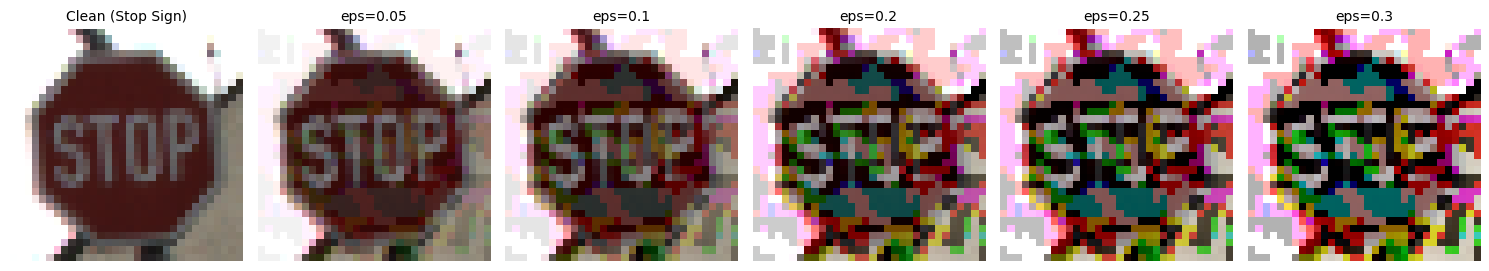

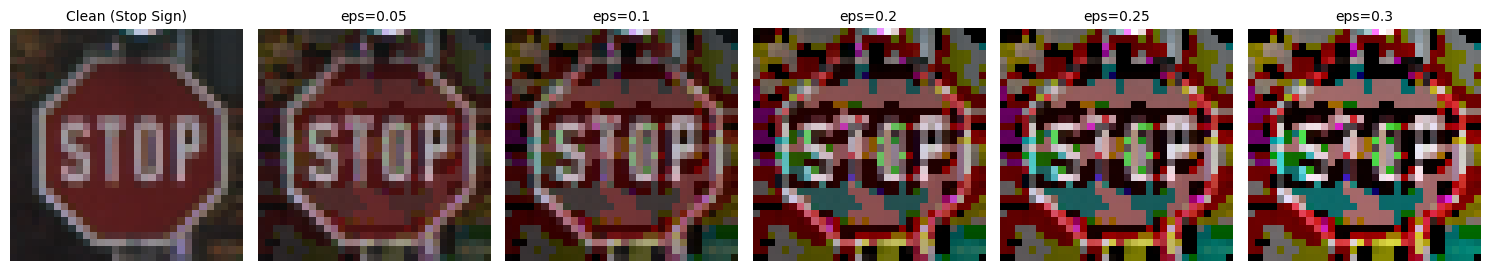

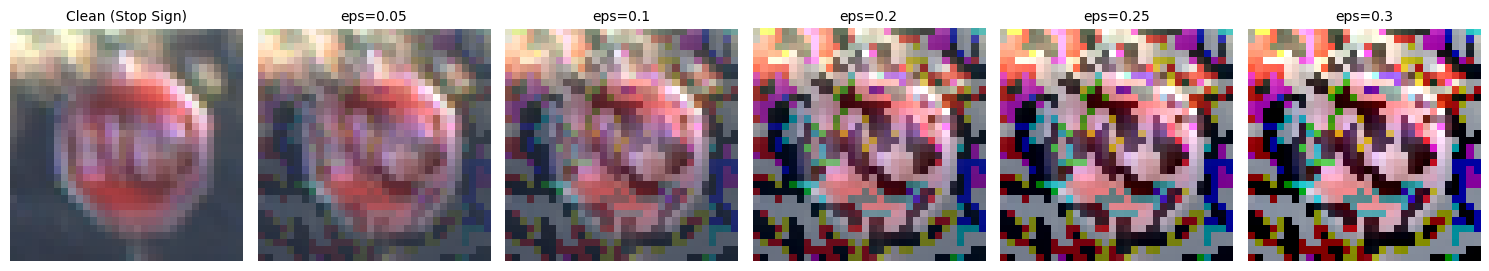

In [ ]:
# Save the adversarial samples for each epsilon value
for eps in epsilons:
    np.save(MODEL_DIR + f'adv_samples_fgsm_targeted_eps_{eps}.npy', adv_samples_fgsm_targeted[eps])

# Save the accuracy results
np.save(MODEL_DIR + 'fgsm_targeted_accuracy_results.npy', accuracy_fgsm_targeted)

indices = [0, 1, 2]

for idx in indices:
    plt.figure(figsize=(15, 5))

    plt.subplot(1, len(epsilons) + 1, 1)
    plt.imshow(stop_sign_images[idx])
    plt.title('Clean (Stop Sign)', fontsize=10)
    plt.axis('off')

    for j, eps in enumerate(epsilons):
        plt.subplot(1, len(epsilons) + 1, j + 2)
        plt.imshow(adv_samples_fgsm_targeted[eps][idx])
        plt.title(f'eps={eps}', fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Targetted PGD Attack
epsilons = [0.05, 0.1, 0.2, 0.25, 0.3]
pgd_attackers = {}

for eps in epsilons:
    pgd_attackers[eps] = ProjectedGradientDescent(estimator=classifier, eps=eps, max_iter=20, targeted=True)

adv_samples_pgd_targeted = {}

for eps in epsilons:
    adv_samples_pgd_targeted[eps] = pgd_attackers[eps].generate(x=stop_sign_images, y=target_labels)

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
accuracy_pgd_targeted = {}

for eps in epsilons:
    preds_adv = classifier.predict(adv_samples_pgd_targeted[eps])
    accuracy_pgd_targeted[eps] = np.mean(np.argmax(preds_adv, axis=1) == 1)  # Target: Speed Limit 30
    print(f"Targeted PGD Attack Accuracy for eps={eps}: {accuracy_pgd_targeted[eps]}")

Targeted PGD Attack Accuracy for eps=0.05: 0.003703703703703704
Targeted PGD Attack Accuracy for eps=0.1: 0.007407407407407408
Targeted PGD Attack Accuracy for eps=0.2: 0.0
Targeted PGD Attack Accuracy for eps=0.25: 0.0
Targeted PGD Attack Accuracy for eps=0.3: 0.0


In [ ]:
# Save the adversarial samples for each epsilon value
for eps in epsilons:
    np.save(MODEL_DIR + f'adv_samples_pgd_targeted_eps_{eps}.npy', adv_samples_pgd_targeted[eps])

# Save the accuracy results
np.save(MODEL_DIR + 'pgd_targeted_accuracy_results.npy', accuracy_pgd_targeted)

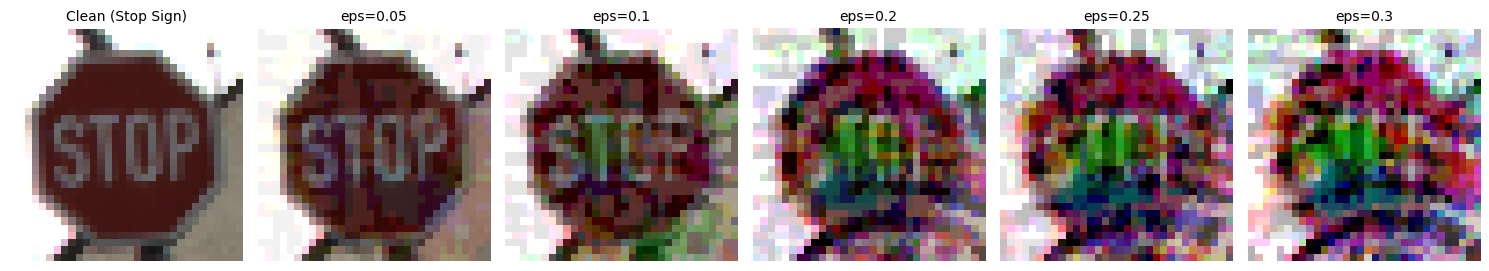

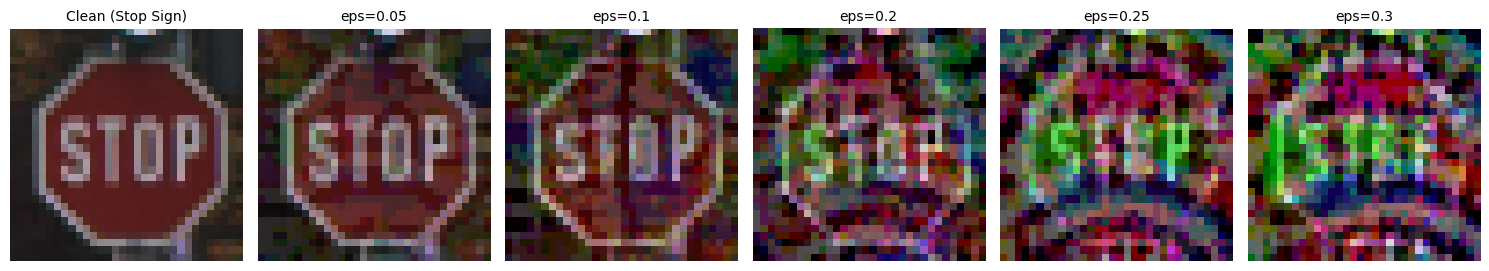

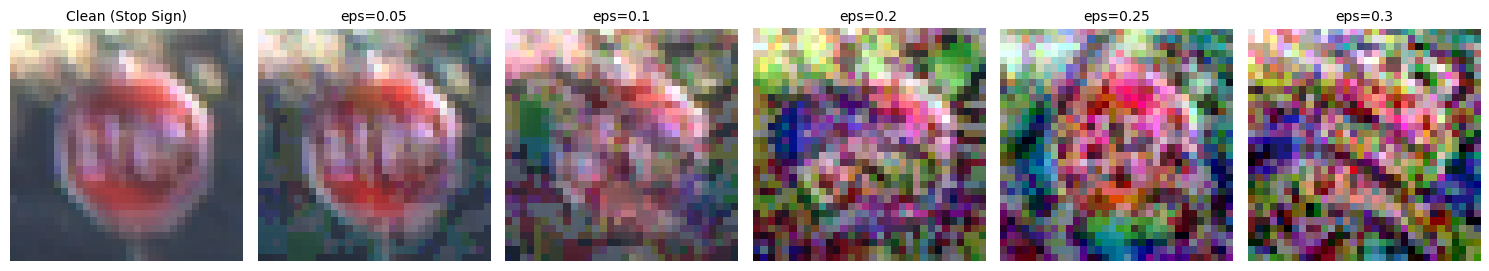

In [ ]:
indices = [0, 1, 2]

for idx in indices:
    plt.figure(figsize=(15, 5))

    plt.subplot(1, len(epsilons) + 1, 1)
    plt.imshow(stop_sign_images[idx])
    plt.title('Clean (Stop Sign)', fontsize=10)
    plt.axis('off')

    for j, eps in enumerate(epsilons):
        plt.subplot(1, len(epsilons) + 1, j + 2)
        plt.imshow(adv_samples_pgd_targeted[eps][idx])
        plt.title(f'eps={eps}', fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Targetted C&W L2 Attack
cw_l2 = CarliniL2Method(classifier=classifier, targeted=True, max_iter=10)

adv_samples_cw_l2_targeted = cw_l2.generate(x=stop_sign_images, y=target_labels)

epsilons = [0.05, 0.1, 0.2, 0.25, 0.3]
adv_samples_cw_l2_scaled = {}

for eps in epsilons:
    adv_samples_cw_l2_scaled[eps] = stop_sign_images + eps * (adv_samples_cw_l2_targeted - stop_sign_images)

C&W L_2:   0%|          | 0/270 [00:00<?, ?it/s]

Targeted C&W L2 Attack Accuracy for eps=0.05: 0.0
Targeted C&W L2 Attack Accuracy for eps=0.1: 0.0
Targeted C&W L2 Attack Accuracy for eps=0.2: 0.0
Targeted C&W L2 Attack Accuracy for eps=0.25: 0.0
Targeted C&W L2 Attack Accuracy for eps=0.3: 0.0


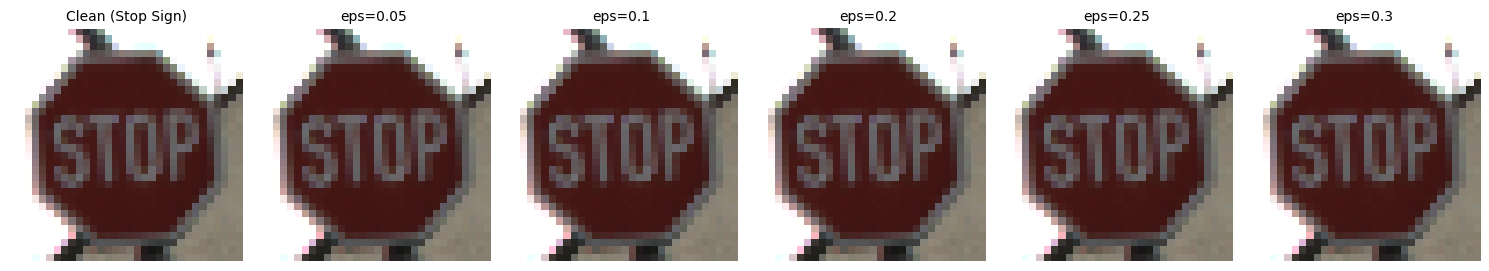

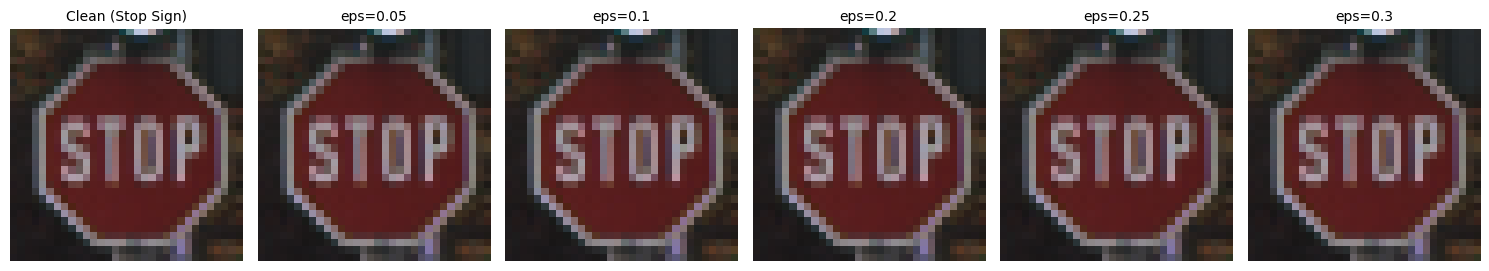

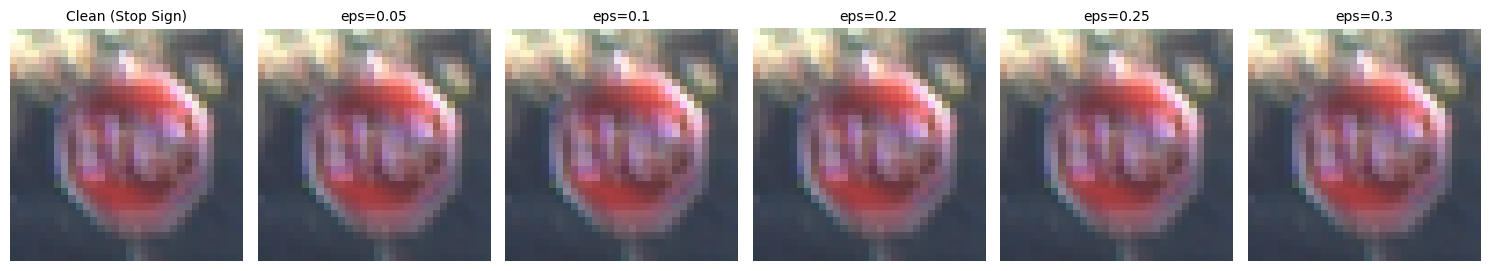

In [ ]:
# Evaluate
accuracy_cw_l2_targeted = {}

for eps in epsilons:
    preds_adv = classifier.predict(adv_samples_cw_l2_scaled[eps])
    accuracy_cw_l2_targeted[eps] = np.mean(np.argmax(preds_adv, axis=1) == 1)  # Target: Speed Limit 30
    print(f"Targeted C&W L2 Attack Accuracy for eps={eps}: {accuracy_cw_l2_targeted[eps]}")

# Save the adversarial samples for each epsilon value
for eps in epsilons:
    np.save(MODEL_DIR + f'adv_samples_cw_l2_targeted_eps_{eps}.npy', adv_samples_cw_l2_scaled[eps])

# Save the accuracy results
np.save(MODEL_DIR + 'cw_l2_targeted_accuracy_results.npy', accuracy_cw_l2_targeted)

# Plot
indices = [0, 1, 2]

for idx in indices:
    plt.figure(figsize=(15, 5))
    plt.subplot(1, len(epsilons) + 1, 1)
    plt.imshow(stop_sign_images[idx])
    plt.title('Clean (Stop Sign)', fontsize=10)
    plt.axis('off')

    for j, eps in enumerate(epsilons):
        plt.subplot(1, len(epsilons) + 1, j + 2)
        plt.imshow(adv_samples_cw_l2_scaled[eps][idx])
        plt.title(f'eps={eps}', fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Filter Speed Limit 30 sign images (label 1)
speed_30_indices = np.where(labels_adv == 1)[0]  # Find indices of Speed Limit 30 sign images
speed_30_images = imgs_adv[speed_30_indices]  # Retrieve Speed Limit 30 sign images

In [ ]:
# Target labels for misclassification: misclassify Speed Limit 30 sign images as Stop signs (label 14)
target_labels = np.ones_like(speed_30_indices) * 14  # Set target label to Stop sign (label 14)

# Convert target labels to one-hot encoding for ART classifier
target_labels_cat = to_categorical(target_labels, NUM_LABELS)

In [ ]:
# Generate adversarial examples for C&W L2 attack (targeted attack)
adv_samples_cw_l2_speed_30 = cw_l2.generate(x=speed_30_images, y=target_labels_cat)

C&W L_2:   0%|          | 0/27 [00:00<?, ?it/s]

In [ ]:
# Initialize dictionaries for FGSM and PGD
adv_samples_fgsm_speed_30 = {}
adv_samples_pgd_speed_30 = {}

# Target labels for misclassification (target Stop sign, label 14)
target_labels_cat = to_categorical(np.ones_like(speed_30_indices) * 14, NUM_LABELS)

In [ ]:
# Generate adversarial examples for FGSM and PGD targeted attacks
for eps in epsilons:
    adv_samples_fgsm_speed_30[eps] = fgsm_attackers[eps].generate(x=speed_30_images, y=target_labels_cat)
    adv_samples_pgd_speed_30[eps] = pgd_attackers[eps].generate(x=speed_30_images, y=target_labels_cat)

# Calculate accuracy for FGSM, PGD, and C&W L2 on Speed Limit 30 images
accuracy_fgsm_speed_30 = {}
accuracy_pgd_speed_30 = {}
accuracy_cw_l2_speed_30 = np.mean(np.argmax(classifier.predict(adv_samples_cw_l2_speed_30), axis=1) == np.argmax(labels_adv_cat[speed_30_indices], axis=1))

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

PGD - Random Initializations:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Iterations:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
for eps in epsilons:
    preds_fgsm = classifier.predict(adv_samples_fgsm_speed_30[eps])
    preds_pgd = classifier.predict(adv_samples_pgd_speed_30[eps])

    accuracy_fgsm_speed_30[eps] = np.mean(np.argmax(preds_fgsm, axis=1) == np.argmax(labels_adv_cat[speed_30_indices], axis=1))
    accuracy_pgd_speed_30[eps] = np.mean(np.argmax(preds_pgd, axis=1) == np.argmax(labels_adv_cat[speed_30_indices], axis=1))

    # Print the accuracy for each attack and epsilon
    print(f"FGSM Targeted Accuracy for Speed Limit 30 sign images (eps={eps}): {accuracy_fgsm_speed_30[eps]}")
    print(f"PGD Targeted Accuracy for Speed Limit 30 sign images (eps={eps}): {accuracy_pgd_speed_30[eps]}")

print(f"C&W L2 Targeted Accuracy for Speed Limit 30 sign images: {accuracy_cw_l2_speed_30}")

FGSM Targeted Accuracy for Speed Limit 30 sign images (eps=0.05): 0.2222222222222222
PGD Targeted Accuracy for Speed Limit 30 sign images (eps=0.05): 0.5555555555555556
FGSM Targeted Accuracy for Speed Limit 30 sign images (eps=0.1): 0.037037037037037035
PGD Targeted Accuracy for Speed Limit 30 sign images (eps=0.1): 0.14814814814814814
FGSM Targeted Accuracy for Speed Limit 30 sign images (eps=0.2): 0.0
PGD Targeted Accuracy for Speed Limit 30 sign images (eps=0.2): 0.037037037037037035
FGSM Targeted Accuracy for Speed Limit 30 sign images (eps=0.25): 0.0
PGD Targeted Accuracy for Speed Limit 30 sign images (eps=0.25): 0.0
FGSM Targeted Accuracy for Speed Limit 30 sign images (eps=0.3): 0.0
PGD Targeted Accuracy for Speed Limit 30 sign images (eps=0.3): 0.0
C&W L2 Targeted Accuracy for Speed Limit 30 sign images: 1.0


##Task 3 Adversarial Defense
Now let’s defend against adversarial attacks. This [notebook](https://github.com/Trusted-AI/adversarial-robustness-toolbox/blob/main/notebooks/adversarial_training_mnist.ipynb) is a good start for adversarial training.

Due to its complexity and the time taken to build an adversarial-trained model, we decided to give the model to you, and your only task will be to analyze it. The VGG classifier from earlier parts is used to build the adversarial model. New adversarial images were generated and used to build the new model. This model is provided in your assignment, and you will need to analyze it.



#Code used to build the model


In [ ]:
# from art.estimators.classification import KerasClassifier
# from art.defences.trainer import AdversarialTrainer
# from art.attacks.evasion import ProjectedGradientDescent,FastGradientMethod


model = load_model( MODEL_DIR +'VGG_best.h5')

# robustClassifier = KerasClassifier(model=model, clip_values=(0, 1), use_logits = False)


# attackPgd = ProjectedGradientDescent(estimator = robustClassifier,
#                                         eps=0.1,
#                                         max_iter=40,
#                                         batch_size=64)


# advTrainer = AdversarialTrainer(robustClassifier,attackFGSM,ratio=.5)


# advTrainer.fit(imgs_train, labels_train_cat, nb_epochs=25, batch_size=16)

# model.save(PROJECT_ROOT_DIR + MODEL_DIR +'adversarial_vgg.h5')

In [ ]:
# Load the adversarially trained model
adv_trained_model = load_model(MODEL_DIR + 'adversarial_pgd.h5')

#Your analysis

In [ ]:
#Perform your analysis

# Measure the performance of the trained robust model and compare it to the original VGG model used in earlier parts.
# For the attack part, we will use FGSM and PGD on the samples we reserved for adversarial generation in the earlier parts.
# Record the classification accuracies that have been attacked.

# Evaluate on clean training images
clean_train_accuracy_vgg = model.evaluate(imgs_train, labels_train_cat, verbose=0)[1]
clean_train_accuracy_adv = adv_trained_model.evaluate(imgs_train, labels_train_cat, verbose=0)[1]

# Evaluate on clean set of test images
clean_test_accuracy_vgg = model.evaluate(imgs_test, labels_test_cat, verbose=0)[1]
clean_test_accuracy_adv = adv_trained_model.evaluate(imgs_test, labels_test_cat, verbose=0)[1]

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


In [ ]:
print(f"Clean Train Accuracy VGG: {clean_train_accuracy_vgg}")
print(f"Clean Train Accuracy Adversarial: {clean_train_accuracy_adv}")
print(f"Clean Test Accuracy VGG: {clean_test_accuracy_vgg}")
print(f"Clean Test Accuracy Adversarial: {clean_test_accuracy_adv}")

Clean Train Accuracy VGG: 0.9704589247703552
Clean Train Accuracy Adversarial: 0.9973275065422058
Clean Test Accuracy VGG: 0.9396674633026123
Clean Test Accuracy Adversarial: 0.9677751660346985


In [ ]:
# Load the saved adversarial samples for FGSM and PGD with eps=0.1
fgsm_adv_samples = np.load(MODEL_DIR + 'adv_samples_fgsm_eps_0.1.npy')
pgd_adv_samples = np.load(MODEL_DIR + 'adv_samples_pgd_eps_0.1.npy')

labels_adv_subset = labels_test_cat[:500]

# Evaluate the adversarially trained model on FGSM and PGD adversarial samples
fgsm_accuracy_adv = adv_trained_model.evaluate(fgsm_adv_samples, labels_adv_subset, verbose=0)[1]
pgd_accuracy_adv = adv_trained_model.evaluate(pgd_adv_samples, labels_adv_subset, verbose=0)[1]

print(f"Adversarially Trained Model Accuracy on FGSM Attacked Images: {fgsm_accuracy_adv}")
print(f"Adversarially Trained Model Accuracy on PGD Attacked Images: {pgd_accuracy_adv}")

# Compare to the original VGG16 model accuracy (use the same subset of labels)
fgsm_accuracy_vgg = model.evaluate(fgsm_adv_samples, labels_adv_subset, verbose=0)[1]
pgd_accuracy_vgg = model.evaluate(pgd_adv_samples, labels_adv_subset, verbose=0)[1]

print(f"VGG16 Model Accuracy on FGSM Attacked Images: {fgsm_accuracy_vgg}")
print(f"VGG16 Model Accuracy on PGD Attacked Images: {pgd_accuracy_vgg}")

Adversarially Trained Model Accuracy on FGSM Attacked Images: 0.4580000042915344
Adversarially Trained Model Accuracy on PGD Attacked Images: 0.515999972820282
VGG16 Model Accuracy on FGSM Attacked Images: 0.22599999606609344
VGG16 Model Accuracy on PGD Attacked Images: 0.07999999821186066
